## Import Libraries

In [ ]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.augmentations import transforms as AT
from albumentations.pytorch import ToTensorV2

## Import Env File

In [4]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Parameters

In [5]:
classes = ['jogja', 'pekalongan']
image_size = (224, 224) 
test_split_ratio = 0.2

## GLCM Function

In [6]:
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

## Data Augmentation

In [ ]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.05, 0.05), rotate=15, p=0.4)  # Pengganti ShiftScaleRotate
])

## Load The Dataset and Extract The Features

In [52]:
features = []
labels = []

for class_idx, class_name in enumerate(classes):
    folder = os.path.join(datasets_path, class_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, image_size)

        # Augmentasi gambar
        augmented = augment(image=image)
        aug_image = augmented['image']

        glcm_features_aug = extract_glcm_features(aug_image)
        features.append(glcm_features_aug)
        labels.append(class_idx)

features = np.array(features)
labels = np.array(labels)

## Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_split_ratio, random_state=42)

In [54]:
# Melihat 10 baris pertama dari X_train
print("X_train sebelum normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sebelum normalisasi (10 baris pertama):
[[3.92952534e+02 6.49161195e+00 7.49152361e-01 5.51934263e-01
  9.82032742e-01]
 [4.58249059e+02 1.36321469e+01 1.94491230e-01 9.65653164e-02
  9.37897308e-01]
 [5.53096312e+02 1.50312100e+01 2.09803355e-01 8.95856346e-02
  7.71712501e-01]
 [1.18746485e+03 2.17104020e+01 1.02814998e-01 1.76104731e-02
  6.65513298e-01]
 [4.65692825e+02 1.51685218e+01 1.86150844e-01 1.28333892e-01
  9.14988740e-01]
 [3.62151285e+02 1.25519899e+01 2.35400501e-01 1.73787483e-01
  9.52720707e-01]
 [1.47387876e+03 2.62475977e+01 1.39264738e-01 8.25082756e-02
  8.42480472e-01]
 [2.10737806e+03 2.80562340e+01 2.39533075e-01 1.15852176e-01
  8.43125281e-01]
 [2.64993173e+02 1.09752763e+01 1.76292013e-01 8.46250476e-02
  9.31365685e-01]
 [3.40633628e+03 3.16377322e+01 1.81248904e-01 1.67394786e-02
  7.38883137e-01]]


In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)        

In [56]:
# Melihat 10 baris pertama dari X_train
print("X_train sesudah normalisasi (10 baris pertama):")
print(X_train[:10])

X_train sesudah normalisasi (10 baris pertama):
[[-0.81189258 -1.34818468  2.94971414  3.46163547  1.06094937]
 [-0.76165003 -0.67756324 -0.3591043  -0.22204257  0.76839492]
 [-0.68866961 -0.54616668 -0.26776017 -0.27850426 -0.33317132]
 [-0.2005534   0.08112657 -0.90599679 -0.86074273 -1.03711929]
 [-0.75592241 -0.53327069 -0.40885869  0.0349473   0.61654407]
 [-0.83559266 -0.77900892 -0.11506097  0.40264122  0.86665274]
 [ 0.0198284   0.50724881 -0.68855669 -0.3357561   0.13591854]
 [ 0.50727577  0.67711147 -0.09040819 -0.06602275  0.14019269]
 [-0.91035118 -0.92708998 -0.46767132 -0.31863261  0.72509966]
 [ 1.50676193  1.01347696 -0.4381011  -0.86778859 -0.55078279]]


In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [57]:
print("X_train shape:", X_train.shape)
print("X_train_pca shape:", X_train_pca.shape)

X_train shape: (157, 5)
X_train_pca shape: (157, 3)


In [47]:
# Melihat 10 baris pertama dari X_train_pca
print("X_train_pca (10 baris pertama):")
print(X_train_pca[:10])

X_train_pca (10 baris pertama):
[[-4.03580348e+00  4.02713944e+00 -9.42372465e-01]
 [-9.55877830e-01 -1.05125841e+00  2.12013538e-01]
 [ 1.98177213e+00 -3.84048701e-01 -1.78453834e+00]
 [-6.34150671e-01 -4.35945540e-01 -1.85194194e-01]
 [-1.62255600e-03 -8.46855828e-01  2.99233512e-03]
 [ 1.81429844e+00 -7.55879308e-01 -6.09969651e-01]
 [ 1.94693349e+00 -3.45543532e-01  3.10957959e-02]
 [ 1.48017805e+00 -2.28054259e-01  5.92470746e-01]
 [-1.52445825e+00 -9.91561119e-01  8.70628996e-02]
 [ 5.54259544e-01 -5.61237362e-01  4.97410602e-01]]


## Train SVM

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Untuk kernel linear
param_grid_linear = {
    'kernel': ['linear'],
    'C': [0.1, 1, 10, 100],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel RBF
param_grid_rbf = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'class_weight': [None, 'balanced']
}

# Untuk kernel poly
param_grid_poly = {
    'kernel': ['poly'],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 0.1, 0.5],
    'shrinking': [True, False],
    'tol': [1e-3],
    'class_weight': [None]
}

# Gabungkan semua grid
param_grid = [param_grid_linear, param_grid_rbf, param_grid_poly]

grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_train_pca, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Fitting 5 folds for each of 188 candidates, totalling 940 fits
Best parameters: {'C': 10, 'class_weight': None, 'coef0': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True, 'tol': 0.001}
Best cross-validation score: 0.6060483870967741


In [49]:
from sklearn.svm import SVC

# Gunakan parameter terbaik dari GridSearchCV
best_model = SVC(C=10, class_weight=None, coef0=0.1, degree=3, gamma='scale', kernel='poly', shrinking=True, tol=0.001)
best_model.fit(X_train_pca, y_train)


SVC(C=10, coef0=0.1, kernel='poly')

## Evaluates

In [50]:
# Evaluasi model
y_pred = best_model.predict(X_test_pca)

from sklearn.metrics import classification_report, confusion_matrix
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.625
              precision    recall  f1-score   support

           0       0.62      0.76      0.68        21
           1       0.64      0.47      0.55        19

    accuracy                           0.62        40
   macro avg       0.63      0.62      0.61        40
weighted avg       0.63      0.62      0.62        40



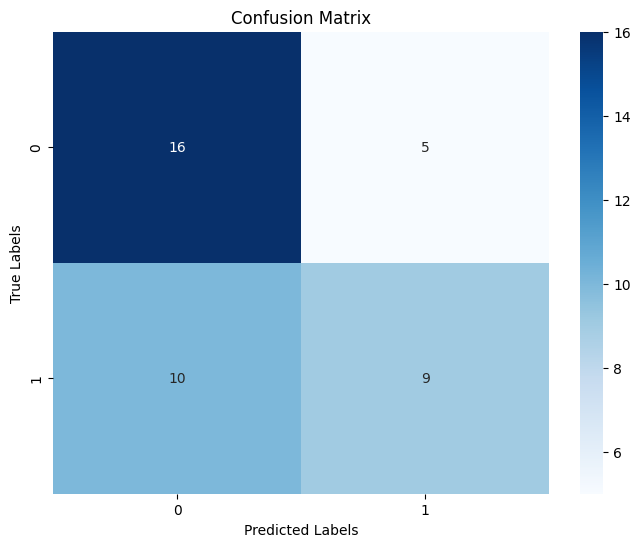

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan dengan heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [61]:
from joblib import dump

# Simpan model ke file
dump(best_model, models_path+'/svm_glcm_model.joblib')
print("Model berhasil disimpan ke svm_glcm_model.joblib")

Model berhasil disimpan ke svm_glcm_model.joblib
